In [3]:
using Pkg
Pkg.instantiate()

    Updating registry at `~/.julia/registries/General.toml`
   Installed Tracy ───────────────────── v0.1.6
   Installed Accessors ───────────────── v0.1.43
   Installed SciMLPublic ─────────────── v1.0.1
   Installed LoggingExtras ───────────── v1.2.0
   Installed Preferences ─────────────── v1.5.1
   Installed SparseBandedMatrices ────── v1.3.0
   Installed StaticArrays ────────────── v1.9.16
   Installed NNlib ───────────────────── v0.9.33
   Installed EnumX ───────────────────── v1.0.6
   Installed Polyester ───────────────── v0.7.18
   Installed Optimisers ──────────────── v0.4.7
   Installed OpenSSL ─────────────────── v1.6.1
   Installed RecursiveArrayTools ─────── v3.46.0
   Installed FileIO ──────────────────── v1.17.1
   Installed HTTP ────────────────────── v1.10.19
   Installed DataFrames ──────────────── v1.8.1
   Installed BFloat16s ───────────────── v0.6.1
   Installed LibTracyClient_jll ──────── v0.13.1+0
   Installed CUDA_Runtime_jll ────────── v0.19.2+0
   Installed S

In [20]:
using Pkg
Pkg.add(url="https://github.com/gher-uliege/OceanPlot.jl",rev="master")

    Updating git-repo `https://github.com/gher-uliege/OceanPlot.jl`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [21]:
using OceanPlot

In [1]:
# Loading libraries
using Dates
using DINCAE
using LinearAlgebra
using NCDatasets
using Printf
using Random
using DIVAnd
using Glob
using JSON3
using DataStructures
using IntervalSets
using CSV
using DataFrames
using Statistics
using PyPlot
include("/gpfs/home/acad/ulg-gher/abeldech/testDEMO/DINCAE-benthic-traits/src/neccton_common.jl")

saveinterp

In [2]:
pwd()

"/gpfs/home/acad/ulg-gher/abeldech/testDEMO/DINCAE-benthic-traits"

In [3]:
function savedata(values,lon,lat,time,id,udates,varname,outname)
    len = length.(values);
    values = reduce(vcat,values);
    lon = reduce(vcat,lon);
    lat = reduce(vcat,lat);
    time = reduce(vcat,time);
    id = reduce(vcat,id);

    ds = NCDataset(outname,"c")

    defVar(ds,"size",len,("track",); attrib = OrderedDict(
        "sample_dimension" => "time"));
    defVar(ds,"dates",DateTime.(udates),("track",))

    defVar(ds,varname,values,("time",))
    defVar(ds,"lon",lon,("time",))
    defVar(ds,"lat",lat,("time",))
    defVar(ds,"id",id,("time",))
    defVar(ds,"dtime",time,("time",), attrib = OrderedDict(
        "long_name" => "time of measurement"))

    close(ds);
end

savedata (generic function with 1 method)

In [4]:
# Define Directories
root = expanduser("~/Reconstruct_Points")

basedir   = joinpath(root, "Datasets")
moddir    = joinpath(root, "ModelOut")
moddirNew = joinpath(root, "ModelNew")
figdir    = joinpath(root, "Datasets", "Figures")
outdir    = joinpath(root, "Datasets", "Results")

datadir = joinpath(root, "Datasets", "BenthicData")
auxdir  = joinpath(root, "Datasets", "Auxdata_$(1/dlon)")

split_fname   = joinpath(root, "Datasets", "split.nc")
station_fname = joinpath(root, "Datasets", "BenthicData", "Stations", "stations.csv")

CWM_response_fname = joinpath(root, "Datasets", "BenthicData", "CWM_SxT", "cwm.csv")

env_matrix_fname = joinpath(root,"Datasets","BenthicData","Environnement","matrice environnement.txt")


"/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/BenthicData/Environnement/matrice environnement.txt"

In [5]:
# Define grid
Δlon = dlon
Δlat = dlat

lonr = gridlon
latr = gridlat

xi = gridlon .+ 0 * gridlat'
yi = 0 * gridlon .+ gridlat'

grid = (lonr,latr)

@show size(lonr)


size(lonr) = (74,)


(74,)

In [6]:
# Separate training and validation dataset
df, resp, station = df_load(station_fname,CWM_response_fname);

env_matrix = CSV.read(env_matrix_fname,DataFrame)
env_matrix = rename(env_matrix, Symbol("Station ID") => :sta)
@assert Set(resp.sta) ⊆ Set(station.sta) # Error if the condition is not fullfilled
setdiff(resp.sta,env_matrix.sta)


fnames0 = sort(glob("Cl*_1d_*_*_btrc_T_*-*.nc",moddir))
fnames = sort(glob("Cl*_1d_*_*_grid_T_*-*.nc",moddir))

lon1, lat1 = neccton_load_coord(fnames)

ds = NCDataset(split_fname);
index_train = ds["index_train"][:];
index_val = ds["index_val"][:];
close(ds)

closed Dataset

In [7]:
# Bathymetry and mask loading

bathname = expanduser("~/Reconstruct_Points/Bathy/DivaData/Global/gebco_30sec_4.nc")
bathisglobal = true
mask,(pm,pn),(xi,yi) = DIVAnd.domain(bathname,bathisglobal,gridlon,gridlat)
hx, hy, h = DIVAnd.load_bath(bathname, bathisglobal, gridlon, gridlat)
#pcolormesh(hx,hy,h')

# Create a file for the mask

maskname = joinpath(basedir,"Results","mask.nc")
if !isfile(maskname)
    NCDataset(maskname,"c") do ds
        defVar(ds,"mask",Int8.(mask),("lon","lat"))
    end
end


In [8]:
# Define stations for training
x = df.Longitude[index_train];
y = df.Latitude[index_train];

x_val = df.Longitude[index_val];
y_val = df.Latitude[index_val];


In [9]:
traits_modalities = filter(s -> !isnothing(match(r"T.*\.M.*",s)),String.(propertynames(df)))


n = "T1.M1"


# For Analysis

for n in traits_modalities
    @show n
    @info "processing" n
    v = df[index_train,n]

    lon = [x]
    lat = [y]
    dtime = [fill(DateTime(1,1,1),size(x))]
    value = [v]
    id = [collect(1:length(v))]
    udates = [DateTime(1,1,1)]

    v = df[index_train,n]

    varname = n

    outname = joinpath(basedir,"DINCAE",varname * ".nc")
    @show outname
    mkpath(dirname(outname))

    savedata(value,lon,lat,dtime,id,udates,varname,outname)
end


# For validation

for n in traits_modalities
    @show n
    @info "processing" n
    v_val = df[index_val,n]

    lon_val = [x_val]
    lat_val = [y_val]
    dtime_val = [fill(DateTime(1,1,1),size(x_val))]
    value_val = [v_val]
    id_val = [collect(1:length(v_val))]
    udates = [DateTime(1,1,1)]

    v_val = df[index_val,n]

    varname = n

    outname = joinpath(basedir,"DINCAE",varname * "_val.nc")
    @show outname
    mkpath(dirname(outname))

    savedata(value_val,lon_val,lat_val,dtime_val,id_val,udates,varname,outname)
end


n = "T1.M1"


┌ Info: processing
└   n = "T1.M1"


outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M1.nc"
n = "T1.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M2.nc"
n = "T1.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M3.nc"
n = "T1.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M4.nc"
n = "T1.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M5.nc"
n = "T2.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T2.M1.nc"
n = "T2.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T2.M2.nc"
n = "T2.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T2.M3.nc"
n = "T3.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T3.M1.nc"
n = "T3.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T3

┌ Info: processing
└   n = "T1.M2"
┌ Info: processing
└   n = "T1.M3"
┌ Info: processing
└   n = "T1.M4"
┌ Info: processing
└   n = "T1.M5"
┌ Info: processing
└   n = "T2.M1"
┌ Info: processing
└   n = "T2.M2"
┌ Info: processing
└   n = "T2.M3"
┌ Info: processing
└   n = "T3.M1"
┌ Info: processing
└   n = "T3.M2"
┌ Info: processing
└   n = "T3.M3"
┌ Info: processing
└   n = "T4.M1"
┌ Info: processing
└   n = "T4.M2"
┌ Info: processing
└   n = "T4.M3"
┌ Info: processing
└   n = "T5.M1"
┌ Info: processing
└   n = "T5.M2"
┌ Info: processing
└   n = "T5.M3"
┌ Info: processing
└   n = "T6.M1"
┌ Info: processing
└   n = "T6.M2"
┌ Info: processing
└   n = "T6.M3"
┌ Info: processing
└   n = "T6.M4"


"T6.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T6.M5.nc"
n = "T6.M6"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T6.M6.nc"
n = "T7.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T7.M1.nc"
n = "T7.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T7.M2.nc"
n = "T7.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T7.M3.nc"
n = "T8.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M1.nc"
n = "T8.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M2.nc"
n = "T8.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M3.nc"
n = "T8.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M4.nc"
n = "T9.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/D

┌ Info: processing
└   n = "T6.M5"
┌ Info: processing
└   n = "T6.M6"
┌ Info: processing
└   n = "T7.M1"
┌ Info: processing
└   n = "T7.M2"
┌ Info: processing
└   n = "T7.M3"
┌ Info: processing
└   n = "T8.M1"
┌ Info: processing
└   n = "T8.M2"
┌ Info: processing
└   n = "T8.M3"
┌ Info: processing
└   n = "T8.M4"
┌ Info: processing
└   n = "T9.M1"
┌ Info: processing
└   n = "T9.M2"
┌ Info: processing
└   n = "T9.M3"
┌ Info: processing
└   n = "T9.M4"
┌ Info: processing
└   n = "T10.M1"
┌ Info: processing
└   n = "T10.M2"
┌ Info: processing
└   n = "T10.M3"
┌ Info: processing
└   n = "T10.M4"
┌ Info: processing
└   n = "T10.M5"
┌ Info: processing
└   n = "T11.M1"
┌ Info: processing
└   n = "T11.M2"
┌ Info: processing
└   n = "T11.M3"


"T11.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T11.M4.nc"
n = "T11.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T11.M5.nc"
n = "T12.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M1.nc"
n = "T12.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M2.nc"
n = "T12.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M3.nc"
n = "T12.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M4.nc"
n = "T12.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M5.nc"
n = "T13.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T13.M1.nc"
n = "T13.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T13.M2.nc"
n = "T13.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruc

┌ Info: processing
└   n = "T11.M4"
┌ Info: processing
└   n = "T11.M5"
┌ Info: processing
└   n = "T12.M1"
┌ Info: processing
└   n = "T12.M2"
┌ Info: processing
└   n = "T12.M3"
┌ Info: processing
└   n = "T12.M4"
┌ Info: processing
└   n = "T12.M5"
┌ Info: processing
└   n = "T13.M1"
┌ Info: processing
└   n = "T13.M2"
┌ Info: processing
└   n = "T13.M3"
┌ Info: processing
└   n = "T13.M4"
┌ Info: processing
└   n = "T14.M1"
┌ Info: processing
└   n = "T14.M2"
┌ Info: processing
└   n = "T14.M3"
┌ Info: processing
└   n = "T14.M4"
┌ Info: processing
└   n = "T14.M5"
┌ Info: processing
└   n = "T14.M6"
┌ Info: processing
└   n = "T15.M1"
┌ Info: processing
└   n = "T15.M2"
┌ Info: processing
└   n = "T15.M3"
┌ Info: processing
└   n = "T15.M4"


"T15.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T15.M5.nc"
n = "T16.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M1.nc"
n = "T16.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M2.nc"
n = "T16.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M3.nc"
n = "T16.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M4.nc"
n = "T16.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M5.nc"
n = "T17.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M1.nc"
n = "T17.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M2.nc"
n = "T17.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M3.nc"
n = "T17.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruc

┌ Info: processing
└   n = "T15.M5"
┌ Info: processing
└   n = "T16.M1"
┌ Info: processing
└   n = "T16.M2"
┌ Info: processing
└   n = "T16.M3"
┌ Info: processing
└   n = "T16.M4"
┌ Info: processing
└   n = "T16.M5"
┌ Info: processing
└   n = "T17.M1"
┌ Info: processing
└   n = "T17.M2"
┌ Info: processing
└   n = "T17.M3"
┌ Info: processing
└   n = "T17.M4"
┌ Info: processing
└   n = "T17.M5"
┌ Info: processing
└   n = "T18.M1"
┌ Info: processing
└   n = "T18.M2"
┌ Info: processing
└   n = "T18.M3"
┌ Info: processing
└   n = "T18.M4"
┌ Info: processing
└   n = "T18.M5"
┌ Info: processing
└   n = "T18.M6"
┌ Info: processing
└   n = "T19.M1"
┌ Info: processing
└   n = "T19.M2"
┌ Info: processing
└   n = "T19.M3"
┌ Info: processing
└   n = "T19.M4"


"T20.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M1.nc"
n = "T20.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M2.nc"
n = "T20.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M3.nc"
n = "T20.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M4.nc"
n = "T20.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M5.nc"
n = "T20.M6"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M6.nc"
n = "T20.M7"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M7.nc"
n = "T21.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T21.M1.nc"
n = "T21.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T21.M2.nc"
n = "T21.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruc

┌ Info: processing
└   n = "T20.M1"
┌ Info: processing
└   n = "T20.M2"
┌ Info: processing
└   n = "T20.M3"
┌ Info: processing
└   n = "T20.M4"
┌ Info: processing
└   n = "T20.M5"
┌ Info: processing
└   n = "T20.M6"
┌ Info: processing
└   n = "T20.M7"
┌ Info: processing
└   n = "T21.M1"
┌ Info: processing
└   n = "T21.M2"
┌ Info: processing
└   n = "T21.M3"
┌ Info: processing
└   n = "T22.M1"
┌ Info: processing
└   n = "T22.M2"
┌ Info: processing
└   n = "T22.M3"
┌ Info: processing
└   n = "T22.M4"
┌ Info: processing
└   n = "T22.M5"
┌ Info: processing
└   n = "T23.M1"
┌ Info: processing
└   n = "T23.M2"
┌ Info: processing
└   n = "T23.M3"
┌ Info: processing
└   n = "T23.M4"
┌ Info: processing
└   n = "T24.M1"
┌ Info: processing
└   n = "T24.M2"


"T24.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T24.M3.nc"
n = "T25.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M1.nc"
n = "T25.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M2.nc"
n = "T25.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M3.nc"
n = "T25.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M4.nc"
n = "T25.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M5.nc"
n = "T26.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T26.M1.nc"
n = "T26.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T26.M2.nc"
n = "T26.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T26.M3.nc"
n = "T27.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruc

┌ Info: processing
└   n = "T24.M3"
┌ Info: processing
└   n = "T25.M1"
┌ Info: processing
└   n = "T25.M2"
┌ Info: processing
└   n = "T25.M3"
┌ Info: processing
└   n = "T25.M4"
┌ Info: processing
└   n = "T25.M5"
┌ Info: processing
└   n = "T26.M1"
┌ Info: processing
└   n = "T26.M2"
┌ Info: processing
└   n = "T26.M3"
┌ Info: processing
└   n = "T27.M1"
┌ Info: processing
└   n = "T27.M2"
┌ Info: processing
└   n = "T27.M3"
┌ Info: processing
└   n = "T27.M4"


"T1.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M1_val.nc"
n = "T1.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M2_val.nc"
n = "T1.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M3_val.nc"
n = "T1.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M4_val.nc"
n = "T1.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T1.M5_val.nc"
n = "T2.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T2.M1_val.nc"
n = "T2.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T2.M2_val.nc"
n = "T2.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T2.M3_val.nc"
n = "T3.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T3.M1_val.nc"
n = "T3.M2"
outname = "/gpfs/home/acad/ulg-gher/ab

┌ Info: processing
└   n = "T1.M1"
┌ Info: processing
└   n = "T1.M2"
┌ Info: processing
└   n = "T1.M3"
┌ Info: processing
└   n = "T1.M4"
┌ Info: processing
└   n = "T1.M5"
┌ Info: processing
└   n = "T2.M1"
┌ Info: processing
└   n = "T2.M2"
┌ Info: processing
└   n = "T2.M3"
┌ Info: processing
└   n = "T3.M1"
┌ Info: processing
└   n = "T3.M2"
┌ Info: processing
└   n = "T3.M3"
┌ Info: processing
└   n = "T4.M1"
┌ Info: processing
└   n = "T4.M2"
┌ Info: processing
└   n = "T4.M3"
┌ Info: processing
└   n = "T5.M1"
┌ Info: processing
└   n = "T5.M2"
┌ Info: processing
└   n = "T5.M3"
┌ Info: processing
└   n = "T6.M1"
┌ Info: processing
└   n = "T6.M2"
┌ Info: processing
└   n = "T6.M3"
┌ Info: processing
└   n = "T6.M4"
┌ Info: processing
└   n = "T6.M5"


"T6.M6"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T6.M6_val.nc"
n = "T7.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T7.M1_val.nc"
n = "T7.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T7.M2_val.nc"
n = "T7.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T7.M3_val.nc"
n = "T8.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M1_val.nc"
n = "T8.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M2_val.nc"
n = "T8.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M3_val.nc"
n = "T8.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T8.M4_val.nc"
n = "T9.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T9.M1_val.nc"
n = "T9.M2"
outname = "/gpfs/home/acad/ulg-gher/ab

┌ Info: processing
└   n = "T6.M6"
┌ Info: processing
└   n = "T7.M1"
┌ Info: processing
└   n = "T7.M2"
┌ Info: processing
└   n = "T7.M3"
┌ Info: processing
└   n = "T8.M1"
┌ Info: processing
└   n = "T8.M2"
┌ Info: processing
└   n = "T8.M3"
┌ Info: processing
└   n = "T8.M4"
┌ Info: processing
└   n = "T9.M1"
┌ Info: processing
└   n = "T9.M2"
┌ Info: processing
└   n = "T9.M3"
┌ Info: processing
└   n = "T9.M4"
┌ Info: processing
└   n = "T10.M1"
┌ Info: processing
└   n = "T10.M2"
┌ Info: processing
└   n = "T10.M3"
┌ Info: processing
└   n = "T10.M4"
┌ Info: processing
└   n = "T10.M5"
┌ Info: processing
└   n = "T11.M1"
┌ Info: processing
└   n = "T11.M2"
┌ Info: processing
└   n = "T11.M3"
┌ Info: processing
└   n = "T11.M4"
┌ Info: processing
└   n = "T11.M5"


"T12.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M1_val.nc"
n = "T12.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M2_val.nc"
n = "T12.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M3_val.nc"
n = "T12.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M4_val.nc"
n = "T12.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T12.M5_val.nc"
n = "T13.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T13.M1_val.nc"
n = "T13.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T13.M2_val.nc"
n = "T13.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T13.M3_val.nc"
n = "T13.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T13.M4_val.nc"
n = "T14.M1"
outname = "/gpfs/ho

┌ Info: processing
└   n = "T12.M1"
┌ Info: processing
└   n = "T12.M2"
┌ Info: processing
└   n = "T12.M3"
┌ Info: processing
└   n = "T12.M4"
┌ Info: processing
└   n = "T12.M5"
┌ Info: processing
└   n = "T13.M1"
┌ Info: processing
└   n = "T13.M2"
┌ Info: processing
└   n = "T13.M3"
┌ Info: processing
└   n = "T13.M4"
┌ Info: processing
└   n = "T14.M1"
┌ Info: processing
└   n = "T14.M2"
┌ Info: processing
└   n = "T14.M3"
┌ Info: processing
└   n = "T14.M4"
┌ Info: processing
└   n = "T14.M5"
┌ Info: processing
└   n = "T14.M6"
┌ Info: processing
└   n = "T15.M1"
┌ Info: processing
└   n = "T15.M2"
┌ Info: processing
└   n = "T15.M3"
┌ Info: processing
└   n = "T15.M4"
┌ Info: processing
└   n = "T15.M5"
┌ Info: processing
└   n = "T16.M1"
┌ Info: processing
└   n = "T16.M2"


"T16.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M3_val.nc"
n = "T16.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M4_val.nc"
n = "T16.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T16.M5_val.nc"
n = "T17.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M1_val.nc"
n = "T17.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M2_val.nc"
n = "T17.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M3_val.nc"
n = "T17.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M4_val.nc"
n = "T17.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T17.M5_val.nc"
n = "T18.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T18.M1_val.nc"
n = "T18.M2"
outname = "/gpfs/ho

┌ Info: processing
└   n = "T16.M3"
┌ Info: processing
└   n = "T16.M4"
┌ Info: processing
└   n = "T16.M5"
┌ Info: processing
└   n = "T17.M1"
┌ Info: processing
└   n = "T17.M2"
┌ Info: processing
└   n = "T17.M3"
┌ Info: processing
└   n = "T17.M4"
┌ Info: processing
└   n = "T17.M5"
┌ Info: processing
└   n = "T18.M1"
┌ Info: processing
└   n = "T18.M2"
┌ Info: processing
└   n = "T18.M3"
┌ Info: processing
└   n = "T18.M4"
┌ Info: processing
└   n = "T18.M5"
┌ Info: processing
└   n = "T18.M6"
┌ Info: processing
└   n = "T19.M1"
┌ Info: processing
└   n = "T19.M2"
┌ Info: processing
└   n = "T19.M3"
┌ Info: processing
└   n = "T19.M4"
┌ Info: processing
└   n = "T20.M1"
┌ Info: processing
└   n = "T20.M2"
┌ Info: processing
└   n = "T20.M3"


"T20.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M4_val.nc"
n = "T20.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M5_val.nc"
n = "T20.M6"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M6_val.nc"
n = "T20.M7"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T20.M7_val.nc"
n = "T21.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T21.M1_val.nc"
n = "T21.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T21.M2_val.nc"
n = "T21.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T21.M3_val.nc"
n = "T22.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T22.M1_val.nc"
n = "T22.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T22.M2_val.nc"
n = "T22.M3"
outname = "/gpfs/ho

┌ Info: processing
└   n = "T20.M4"
┌ Info: processing
└   n = "T20.M5"
┌ Info: processing
└   n = "T20.M6"
┌ Info: processing
└   n = "T20.M7"
┌ Info: processing
└   n = "T21.M1"
┌ Info: processing
└   n = "T21.M2"
┌ Info: processing
└   n = "T21.M3"
┌ Info: processing
└   n = "T22.M1"
┌ Info: processing
└   n = "T22.M2"
┌ Info: processing
└   n = "T22.M3"
┌ Info: processing
└   n = "T22.M4"
┌ Info: processing
└   n = "T22.M5"
┌ Info: processing
└   n = "T23.M1"
┌ Info: processing
└   n = "T23.M2"
┌ Info: processing
└   n = "T23.M3"
┌ Info: processing
└   n = "T23.M4"
┌ Info: processing
└   n = "T24.M1"
┌ Info: processing
└   n = "T24.M2"
┌ Info: processing
└   n = "T24.M3"
┌ Info: processing
└   n = "T25.M1"


"T25.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M2_val.nc"
n = "T25.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M3_val.nc"
n = "T25.M4"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M4_val.nc"
n = "T25.M5"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T25.M5_val.nc"
n = "T26.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T26.M1_val.nc"
n = "T26.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T26.M2_val.nc"
n = "T26.M3"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T26.M3_val.nc"
n = "T27.M1"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T27.M1_val.nc"
n = "T27.M2"
outname = "/gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/DINCAE/T27.M2_val.nc"
n = "T27.M3"
outname = "/gpfs/ho

┌ Info: processing
└   n = "T25.M2"
┌ Info: processing
└   n = "T25.M3"
┌ Info: processing
└   n = "T25.M4"
┌ Info: processing
└   n = "T25.M5"
┌ Info: processing
└   n = "T26.M1"
┌ Info: processing
└   n = "T26.M2"
┌ Info: processing
└   n = "T26.M3"
┌ Info: processing
└   n = "T27.M1"
┌ Info: processing
└   n = "T27.M2"
┌ Info: processing
└   n = "T27.M3"
┌ Info: processing
└   n = "T27.M4"


In [23]:
# Parametrization 
epochs = 450
probability_skip_for_training = 0.1
learning_rate_decay_epoch = 50
regularization_L2_beta = 0
upsampling_method = :bilinear
learning_rate = 0.004906558111668519
batch_size = 1;
clip_grad = 5.0
save_epochs = [epochs]
enc_nfilter_internal = round.(Int,32 * 2 .^ (0:5))
jitter_std_pos = (0f0,0f0)
ntime_win = 1
skipconnections = 3:length(enc_nfilter_internal)
laplacian_penalty = 0.8f0
loss_weights_refine = (1,)
seed = 12345

laplacian_penalty = Float32(10 ^ (rand(-0..1)))
enc_nfilter_internal = round.(Int,32 * 2 .^ (0:rand(2:5)))

save_epochs = [epochs]

const T = Float32
const F = Float32

grid = (lonr,latr)

Atype = Array{F}



Array{Float32}

In [24]:
# Save results

timestamp = Dates.format(Dates.now(),"yyyy-mm-ddTHHMMSS")
outdir = joinpath(basedir,"Results","DINCAE-$(timestamp)")
mkpath(outdir)
paramsname = joinpath(outdir,"params.json")


open(paramsname,"w") do f
    JSON3.pretty(f,OrderedDict(
        "laplacian_penalty" => laplacian_penalty,
        "epochs" => epochs,
        "batch_size" => batch_size,
        "enc_nfilter_internal" => enc_nfilter_internal,
        "clip_grad" => clip_grad,
        "regularization_L2_beta" => regularization_L2_beta,
        "ntime_win" => ntime_win,
        "upsampling_method" => upsampling_method,
        "loss_weights_refine" => loss_weights_refine,
        "save_epochs" => save_epochs,
        "skipconnections" => skipconnections,
        "dlon" => dlon,
        "dlat" => dlat,
        "jitter_std_pos" => jitter_std_pos,
        "probability_skip_for_training" => probability_skip_for_training,
        "learning_rate" => learning_rate,
        "learning_rate_decay_epoch" => learning_rate_decay_epoch,
        "seed" => seed,
    ))
end

In [25]:
# Load co-variables from NEMO-BMHBI model and sediment type

covars_fname = [
    #(filename = "mean_oxygenbot.nc", varname = "mean_oxygenbot", errvarname = nothing),
    #(filename = "std_oxygenbot.nc",  varname = "std_oxygenbot",  errvarname = nothing),
    #(filename = "mean_DOX.nc",      varname = "mean_dox",      errvarname = nothing),
    #(filename = "std_DOX.nc",       varname = "std_dox",       errvarname = nothing),
    #(filename = "low_DOX.nc",       varname = "low_dox",       errvarname = nothing),
    
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_oxygen",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_fCSED",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_sCSED",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_POC",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "avg_Botflux",       errvarname = nothing),
    (filename = "resized_clim_2008_2018.nc",       varname = "Bath",       errvarname = nothing),

    (filename = "resized_sediments2.nc",       varname = "sediment_type1",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type2",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type3",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type4",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type5",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type6",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type7",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type8",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type9",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type10",       errvarname = nothing),
    (filename = "resized_sediments2.nc",       varname = "sediment_type11",       errvarname = nothing),
]

auxdata_files = map(entry -> (;entry...,filename = joinpath(auxdir,entry.filename)),covars_fname);

In [26]:

# Train the model

index = randn()
# replace varname by the index of the sbatch
mkpath(outdir)


varname = "T16.M2"
root = expanduser("~/Reconstruct_Points")
filename = joinpath(root,"Datasets","DINCAE","$(varname).nc",)
fnames_rec = [joinpath(root,"Datasets","Results","data-avg-$(varname).nc",),]

DINCAE.reconstruct_points(
    T,Atype,filename,varname,grid,fnames_rec;
    learning_rate = learning_rate,
    learning_rate_decay_epoch = learning_rate_decay_epoch,
    epochs = epochs,
    batch_size = batch_size,
    enc_nfilter_internal = enc_nfilter_internal,
    skipconnections = skipconnections,
    clip_grad = clip_grad,
    save_epochs = save_epochs,
    upsampling_method = upsampling_method,
    jitter_std_pos = jitter_std_pos,
    probability_skip_for_training = probability_skip_for_training,
    ntime_win = ntime_win,
    laplacian_penalty = laplacian_penalty,
    auxdata_files = auxdata_files,
    loss_weights_refine = loss_weights_refine,
)


no refine
skip connections at level 4
skip connections at level 3


[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_clim_2008_2018.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_clim_2008_2018.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_clim_2008_2018.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_clim_2008_2018.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_clim_2008_2018.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_clim_2008_2018.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Auxdata_16.0/resized_sediments2.nc
[ Info: remove time mean from /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Data

sum(model(xin)) = 4849.858488091292
size(model(xin)) = (74, 81, 2, 1)
sz = (74, 81, 40)
loss_function(model, xin, xtrue) = 184.50382281608952
epoch:     1 loss 184.6398


[ Info: delete /gpfs/home/acad/ulg-gher/abeldech/Reconstruct_Points/Datasets/Results/data-avg-T16.M2.nc


epoch:     2 loss 3942.6776
epoch:     3 loss 306.8825
epoch:     4 loss 30.2330
epoch:     5 loss 19.0469
epoch:     6 loss 12.3141
epoch:     7 loss 5.5168
epoch:     8 loss 2.2104
epoch:     9 loss 1.8051
epoch:    10 loss 2.5543
epoch:    11 loss 2.3748
epoch:    12 loss 1.6541
epoch:    13 loss 1.0354
epoch:    14 loss 0.5732
epoch:    15 loss 0.3859
epoch:    16 loss 0.3419
epoch:    17 loss 0.1621
epoch:    18 loss -0.0467
epoch:    19 loss -0.1609
epoch:    20 loss -0.2179
epoch:    21 loss -0.3219
epoch:    22 loss -0.4560
epoch:    23 loss -0.6140
epoch:    24 loss -0.6973
epoch:    25 loss -0.7657
epoch:    26 loss -0.7904
epoch:    27 loss -0.8314
epoch:    28 loss -0.8839
epoch:    29 loss -0.9376
epoch:    30 loss -0.9958
epoch:    31 loss -1.0360
epoch:    32 loss -1.0744
epoch:    33 loss -1.0998
epoch:    34 loss -1.1209
epoch:    35 loss -1.1582
epoch:    36 loss -1.1948
epoch:    37 loss -1.2174
epoch:    38 loss -1.2321
epoch:    39 loss -1.2569
epoch:    40 loss -1

450-element Vector{Float64}:
  184.63975197815597
 3942.6775886484074
  306.8824575766224
   30.232972394634622
   19.046865795942292
   12.314119252033821
    5.516808994442466
    2.21035529378665
    1.8050664019220775
    2.5543440326062066
    2.3747974230556372
    1.6540942228960254
    1.0353934828781086
    ⋮
   -2.6193182386960396
   -2.6441834322149953
   -2.6714962117052012
   -2.697336621961601
   -2.7198012828621603
   -2.7514913518507154
   -2.7744774376365506
   -2.8043229589526635
   -2.8290909862367557
   -2.8577197845974496
   -2.880344477943317
   -2.9053238509020907

In [27]:

# Define the results path and load the points for the Plot

fnames_rec = [joinpath(root,"Datasets","Results","data-avg-$(varname).nc",),]
df, resp, station = df_load(station_fname,CWM_response_fname);

In [28]:
# Prepare the Plot

v = df[index_train,varname];
n = varname
cl = quantile(df[:,n],(0.1,0.9))

function plmap(cl;orientation = "horizontal")
    clim(cl)
    colorbar(orientation=orientation);
    xlim(gridlon[[1,end]]); ylim(gridlat[[1,end]])
    OceanPlot.plotmap();
    OceanPlot.set_aspect_ratio()
end

# Load the new dataset from the model

    ds = NCDataset(fnames_rec[1]) 
fi = nomissing(ds[varname][:,:,1])
fi_err = nomissing(ds[varname * "_error"][:,:,1])
    close(ds)

closed Dataset

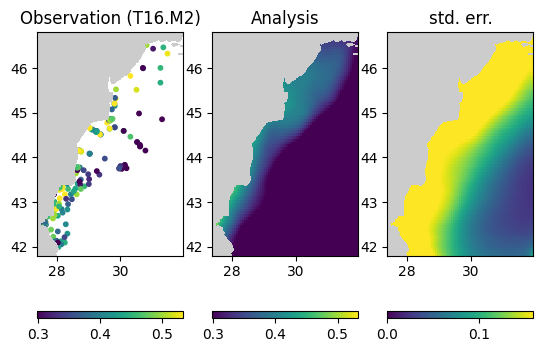

PyObject Text(0.5, 1.0, 'std. err.')

In [29]:
# View the results

    clf();
    subplot(1,3,1); scatter(x,y,10,v); plmap(cl); title("Observation ($n)")
    subplot(1,3,2); pcolor(xi,yi,fi); plmap(cl); title("Analysis")
    subplot(1,3,3); pcolor(xi,yi,fi_err); plmap((0, 0.16)); title("std. err.")
    #savefig(joinpath(figdir,"analysis-$n.png"))